In [41]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from settings import INPUT_PATH
from utils.conn_data import load_pickle
from estimators.DependentBootstrapSampling import DependentBootstrapSampling
from signals.TSM import TSM
from portfolio_tools.Backtest import Backtest

plt.style.use('ggplot')

In [27]:
sysname = "training_etfstsm_moskowitz"
bar_name = "Close"
boot_method = "cbb"
Bsize = 100
k = 100
use_seed = True
inputs = load_pickle(os.path.join(INPUT_PATH, sysname, f"{sysname}.pickle"))
bars_info = inputs["bars"]
instruments = [

    'SPY',
    # 'IWM', 'EEM', 'TLT', 'USO', 'GLD', 'XLF',
    # 'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY', 'XLP',
    # 'XLE', 'AGG', 'DBC', 'HYG', 'LQD','UUP'

]

returns = []
for instrument in instruments:
    tmp_return = np.log(bars_info[instrument][[bar_name]]).diff().dropna()
    returns.append(tmp_return.rename(columns={bar_name: f"{instrument}_returns"}))

returns_info = pd.concat(returns, axis=1)

In [28]:
# generate bootstrap samples from returns
dependent_bootstrap = DependentBootstrapSampling(time_series=torch.tensor(returns_info.to_numpy()),
                                                 boot_method=boot_method,
                                                 Bsize=Bsize,
                                                 use_seed=use_seed)
all_samples = dependent_bootstrap.sample_many_paths(k=k)
n_bootstrap_samples = all_samples.shape[0]

In [29]:
all_samples.shape

torch.Size([100, 4335, 1])

In [32]:
samples = []
for i in range(n_bootstrap_samples):
    sample = pd.DataFrame(all_samples[i, :, :], columns=[f"sample{i}"])
    samples.append(sample)
samples_df = pd.concat(samples, axis=1)

samples_df.head()

,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
0,-0.009175,-0.015714,0.005195,-0.004245,0.024946,0.002534,0.000000,0.012879,-0.000724,0.019357,...,-0.013365,0.004574,0.013938,0.001606,0.005568,-0.005202,0.000069,0.013049,0.008530,0.007864
1,0.010784,-0.001564,-0.012710,0.019712,-0.037656,0.005462,0.000591,0.006760,0.002556,-0.011900,...,0.018662,0.029998,-0.003112,-0.003672,0.000000,-0.005137,0.005775,-0.002097,-0.012712,0.000483
2,0.002085,0.000783,0.001311,0.008499,0.006001,0.001775,0.009212,0.000287,0.000000,0.004366,...,-0.066224,-0.036190,-0.004971,-0.002859,0.006287,0.003603,-0.004800,-0.012555,-0.010050,0.005366
3,-0.000216,0.010403,-0.003281,-0.001010,0.004574,0.001949,0.004374,0.004290,-0.002121,0.018809,...,-0.077133,-0.005987,-0.001710,-0.016653,0.009019,-0.007589,0.003317,0.010672,0.005026,-0.004057
4,-0.000287,-0.003592,0.000516,-0.011303,0.029998,-0.002126,-0.002430,0.000000,-0.006974,0.012186,...,0.052538,-0.032541,0.004128,-0.003108,0.007398,-0.004094,0.004557,0.007610,-0.002678,0.000034


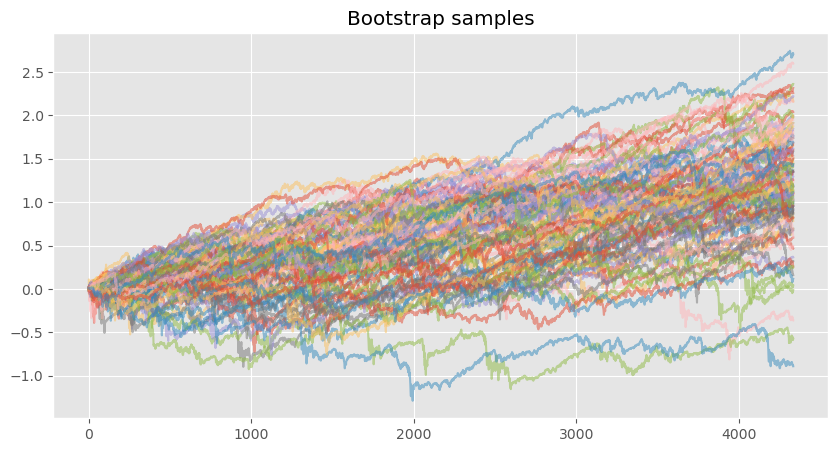

In [33]:
# plot all samples
plt.figure(figsize=(10, 5))
plt.plot(samples_df.cumsum(), alpha=0.5)
plt.title("Bootstrap samples")
plt.show()

In [40]:
window = 252
tsm_signal = TSM()

bootrap_signals = {}
for i in range(n_bootstrap_samples):
    signals = {}
    sample_df = pd.DataFrame(all_samples[i, :, :], columns=instruments, index=returns_info.index)
    for instrument in instruments:
        signal = tsm_signal.Moskowitz(returns=sample_df[[instrument]], window=window)
        signals[instrument] = signal.rename(columns={instrument: bar_name})
    
    bootrap_signals[f"bootstrap_{i}"] = signals
bootstrap_signals_info = bootrap_signals.copy()

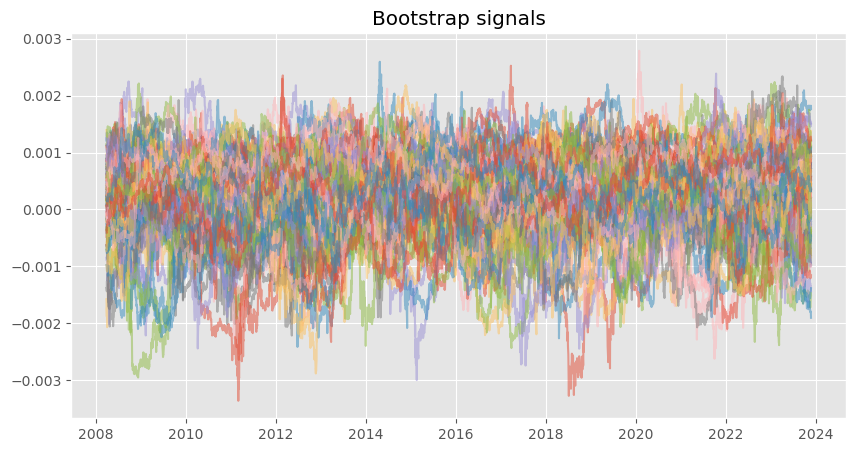

In [39]:
# plot signal
plt.figure(figsize=(10, 5))
for i in range(n_bootstrap_samples):
    plt.plot(bootrap_signals[f"bootstrap_{i}"]["SPY"], alpha=0.5)
plt.title("Bootstrap signals")
plt.show()